In [1]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchmetrics import JaccardIndex
import matplotlib.pyplot as plt
import seaborn as sns

from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune import Checkpoint, ExperimentAnalysis
import tempfile

from dataset.uavid_dataset import UAVidDataset
from models.alexnet_fcn import AlexNetFCN
from losses.focal_loss import PixelwiseFocalLoss
from utils.visualizations import visualize_inference, plot_best_trial_metrics

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
torch.cuda.empty_cache()

In [2]:
START_TRAINING = False

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
mapping = {
    (0, 0, 0): 0,
    (128, 128, 0): 1,
    (128, 64, 128): 2,
    (128, 0, 0): 3,
    (64, 64, 0): 4,
    (64, 0, 128): 5,
    (0, 128, 0): 6,
    (192, 0, 192): 7
}

reversed_mapping = {v: k for k, v in mapping.items()}

data_path = os.path.abspath('/teamspace/studios/this_studio/uavid-semantic-segmentation/uavid_dataset/')

In [5]:
def load_data(root_dir, train_transforms, valid_transforms, mapping, config):
    train_dataset = UAVidDataset(root_dir=root_dir, data_part='train', class_mapping=mapping, transforms=train_transforms)
    valid_dataset = UAVidDataset(root_dir=root_dir, data_part='valid', class_mapping=mapping, transforms=valid_transforms)

    train_loader = DataLoader(
        train_dataset, 
        batch_size=int(config["batch_size"]), 
        shuffle=True, 
        num_workers=2,
        pin_memory=True, 
        persistent_workers=True
    )
    valid_loader = DataLoader(
        valid_dataset, 
        batch_size=int(config["batch_size"]), 
        shuffle=False, 
        num_workers=2, 
        pin_memory=True, 
        persistent_workers=True
    )

    return train_loader, valid_loader

In [6]:
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.25),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=15, p=0.25),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.25),
    A.GaussianBlur(blur_limit=(3, 5), p=0.25),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.Resize(540, 960),
    ToTensorV2(transpose_mask=True)
])

valid_transforms = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.Resize(540, 960),
    ToTensorV2(transpose_mask=True)
])

train_loader, valid_loader = load_data('uavid_dataset/', train_transforms=train_transforms, valid_transforms=valid_transforms, mapping=mapping, config={'batch_size': 32})

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [7]:
images, masks = next(iter(train_loader))

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [8]:
unique, counts = torch.unique(masks.flatten(), return_counts=True)
total = counts.sum()
weights = counts.float() / total

for class_id, count, weight in zip(unique, counts, weights):
    print(f"class {class_id}: {count} pixels ({weight:.4f})")

class 0: 3411356 pixels (0.2056)
class 1: 2375846 pixels (0.1432)
class 2: 1622744 pixels (0.0978)
class 3: 4540567 pixels (0.2737)
class 4: 10112 pixels (0.0006)
class 5: 83678 pixels (0.0050)
class 6: 4365329 pixels (0.2631)
class 7: 179168 pixels (0.0108)


In [9]:
def train_epoch(model: nn.Module, train_loader: DataLoader, criterion: nn.Module, optimizer: optim.Optimizer, device: torch.device, jaccard: JaccardIndex, accumulation_steps: int):
    model.train()
    total_loss = 0
    total_iou = 0
    
    optimizer.zero_grad()

    for i, (data, target) in enumerate(train_loader):
        data = data.float().to(device, non_blocking=True)
        target = target.long().to(device, non_blocking=True)
               
        output = model(data)
        loss = criterion(output, target) / accumulation_steps
        
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
 
        total_loss += loss.item() * accumulation_steps
        
        with torch.no_grad():
            pred = output.argmax(dim=1)
            iou = jaccard(pred, target)
            total_iou += iou.item()
        
        del data, target, output, pred, loss
        
    if (i + 1) % accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()
    
    return total_loss / len(train_loader), total_iou / len(train_loader)


def valid_epoch(model: nn.Module, valid_loader: DataLoader, criterion: nn.Module, device: torch.device, jaccard: JaccardIndex):
    model.eval()
    total_loss = 0
    total_iou = 0

    with torch.no_grad():
        for data, target in valid_loader:
            data = data.float().to(device, non_blocking=True)
            target = target.long().to(device, non_blocking=True)

            output = model(data)
            loss = criterion(output, target)
            
            total_loss += loss.item()

            pred = output.argmax(dim=1)
            iou = jaccard(pred, target)
            total_iou += iou.item()
            
            del data, target, output, pred, loss

    return total_loss / len(valid_loader), total_iou / len(valid_loader)

def evaluate(model: nn.Module, loader: DataLoader, device: torch.device, is_test: bool = False):
    model.eval()
    predictions = []
    targets = []
    image_paths = []

    with torch.no_grad():
        for batch in loader:
            if is_test:
                data, paths = batch
                data = data.float().to(device, non_blocking=True)
                output = model(data)
                pred = output.argmax(dim=1)

                predictions.append(pred.cpu())
            else:
                data, target = batch
                data = data.float().to(device, non_blocking=True)
                target = target.long().to(device, non_blocking=True)
                
                output = model(data)
                pred = output.argmax(dim=1)
                
                predictions.append(pred.cpu())
                targets.append(target.cpu())
            
            del data, output, pred

    predictions = torch.cat(predictions, dim=0)
    
    if is_test:
        return predictions, image_paths
    else:
        targets = torch.cat(targets, dim=0)
        return predictions, targets

In [10]:
def train_alexnet_fcn(config, data_dir=None):
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
    
    train_loader, valid_loader = load_data(
        data_dir, 
        train_transforms=train_transforms, 
        valid_transforms=valid_transforms, 
        mapping=mapping, 
        config=config
    )

    model = AlexNetFCN(8, config.get('dropout_prob', 0.1))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = PixelwiseFocalLoss(alpha=weights.to(device) if weights is not None else None)
    optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config["weight_decay"])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

    epochs = config.get('epochs', 20)

    jaccard = JaccardIndex(task='multiclass', num_classes=8).to(device)

    for epoch in range(epochs):
        try:
            train_loss, train_iou = train_epoch(
                model, train_loader, criterion, optimizer, device, 
                jaccard, accumulation_steps=config.get('accumulation_steps', 4)
            )
            val_loss, val_iou = valid_epoch(model, valid_loader, criterion, device, jaccard)
            
            scheduler.step(val_loss)
            
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            
            with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
                checkpoint_path = os.path.join(temp_checkpoint_dir, "checkpoint.pth")
                torch.save(model.state_dict(), checkpoint_path)
                
                tune.report(
                    {"loss": val_loss, "iou": val_iou, "train_loss": train_loss, "train_iou": train_iou},
                    checkpoint=Checkpoint.from_directory(temp_checkpoint_dir)
                )
        except torch.cuda.OutOfMemoryError as e:
            print(f"OOM Error in epoch {epoch}: {e}")
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            raise e

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

In [11]:
if START_TRAINING:
    alexnet_fcn_config = {
        "lr": tune.loguniform(1e-4, 1e-1),
        "weight_decay": tune.loguniform(1e-6, 1e-2),
        "batch_size": tune.choice([2, 4]),
        "dropout_prob": tune.loguniform(0.1, 0.5),
        "accumulation_steps": tune.choice([4, 8]),
        "epochs": 20
    }

    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=20,
        grace_period=2,
        reduction_factor=2
    )

    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train_alexnet_fcn, data_dir=data_path),
            resources={"cpu": 4, "gpu": 0.5} 
        ),
        param_space=alexnet_fcn_config,
        tune_config=tune.TuneConfig(
            scheduler=scheduler,
            num_samples=10
        )
    )

    alexnet_fcn_results = tuner.fit()

    best_result_alexnet_fcn = alexnet_fcn_results.get_best_result(metric="loss", mode="min")
    print(f"\nBest trial config: {best_result_alexnet_fcn.config}")
    print(f"Best trial final validation IoU: {best_result_alexnet_fcn.metrics['iou']:.4f}")
    print(f"Best trial final validation loss: {best_result_alexnet_fcn.metrics['loss']:.4f}")

In [ ]:
checkpoint_dir = None

try:
    best_result_alexnet_fcn = alexnet_fcn_results.get_best_result(metric="loss", mode="min")
    best_checkpoint = best_result_alexnet_fcn.checkpoint
    with best_checkpoint.as_directory() as checkpoint_dir_path:
        checkpoint_path = os.path.join(checkpoint_dir_path, "checkpoint.pth")
        checkpoint_dir = "/".join(checkpoint_dir_path.split("/")[:-1])
except NameError:
    checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith('checkpoint_')]
    if checkpoint_files:
        latest_checkpoint = sorted(checkpoint_files)[-1]
        checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint, "checkpoint.pth")
    else:
        checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_alexnet_fcn = AlexNetFCN(8)
model_alexnet_fcn.load_state_dict(torch.load(checkpoint_path, map_location=device))
model_alexnet_fcn.to(device)
model_alexnet_fcn.eval()

AlexNetFCN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Conv2d(256, 512, kernel_size=(6, 6), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Dropout2d(p=0.2, inplace=False)
    (3): Conv2d(512, 5

In [13]:
dataset = UAVidDataset(root_dir=data_path, data_part='valid', class_mapping=mapping, transforms=valid_transforms)

loader = DataLoader(
    dataset, 
    batch_size=16, 
    shuffle=True, 
    num_workers=4, 
    pin_memory=True, 
    persistent_workers=True
)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


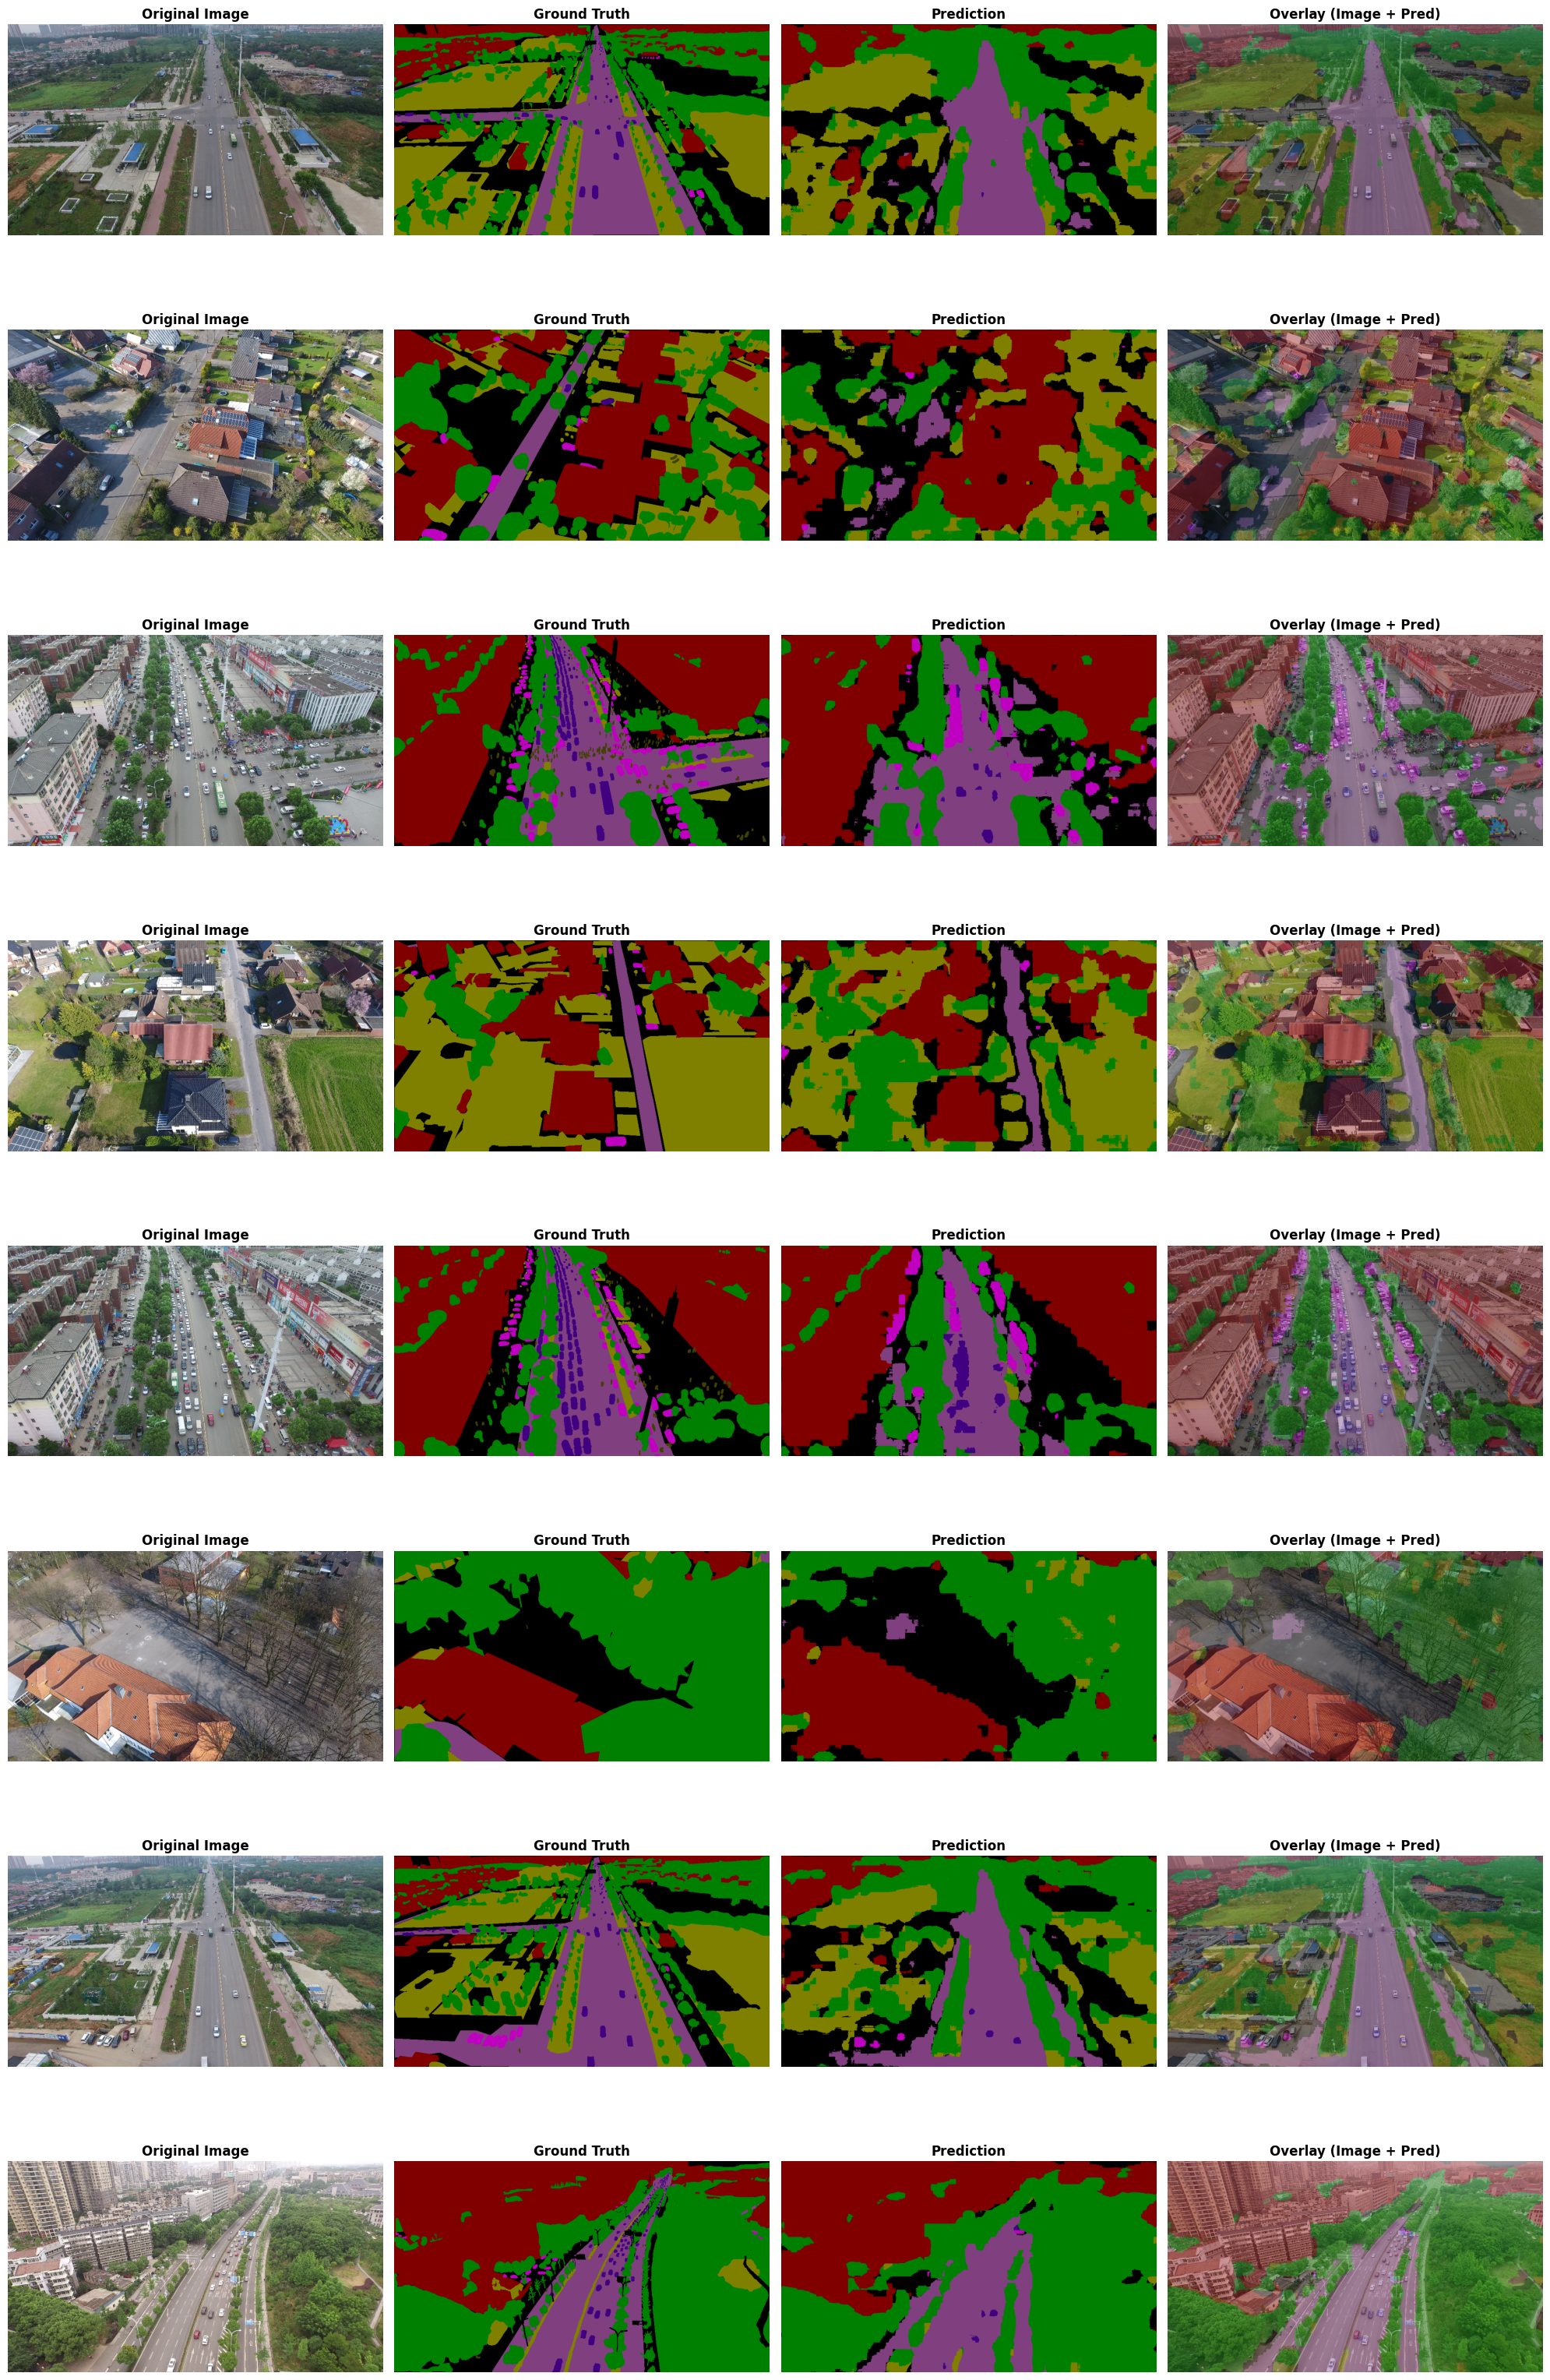

In [17]:
visualize_inference(
    model=model_alexnet_fcn,
    dataloader=loader,
    device=device,
    reversed_mapping=reversed_mapping,
    num_samples=8
)

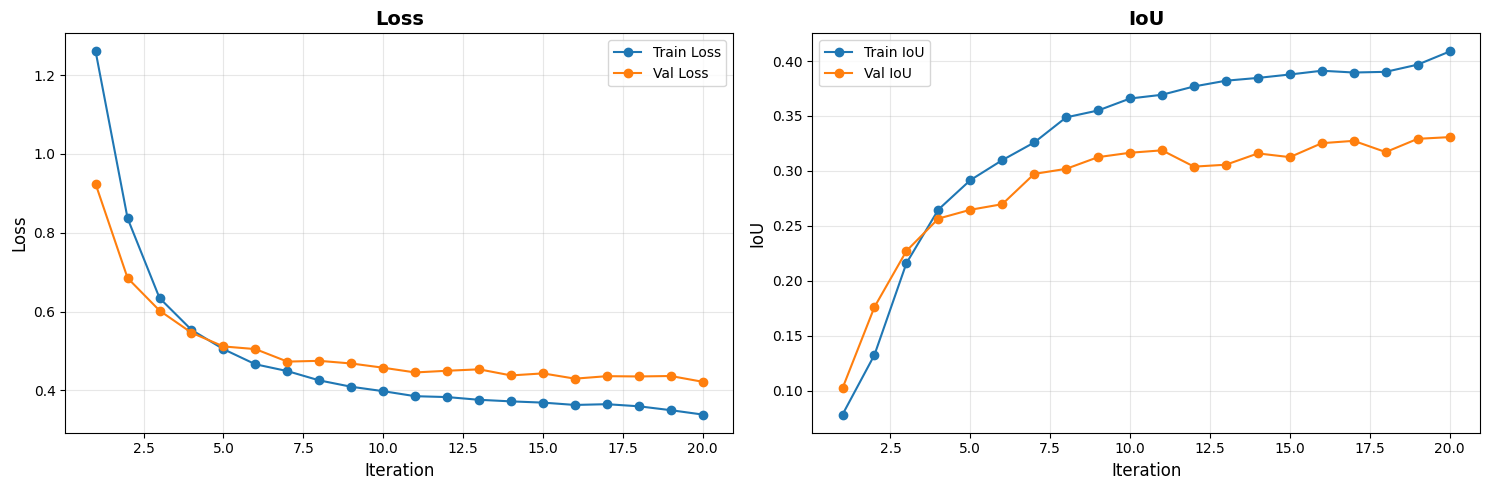

In [18]:
plot_best_trial_metrics(
    f"{checkpoint_dir}/progress.csv"
)

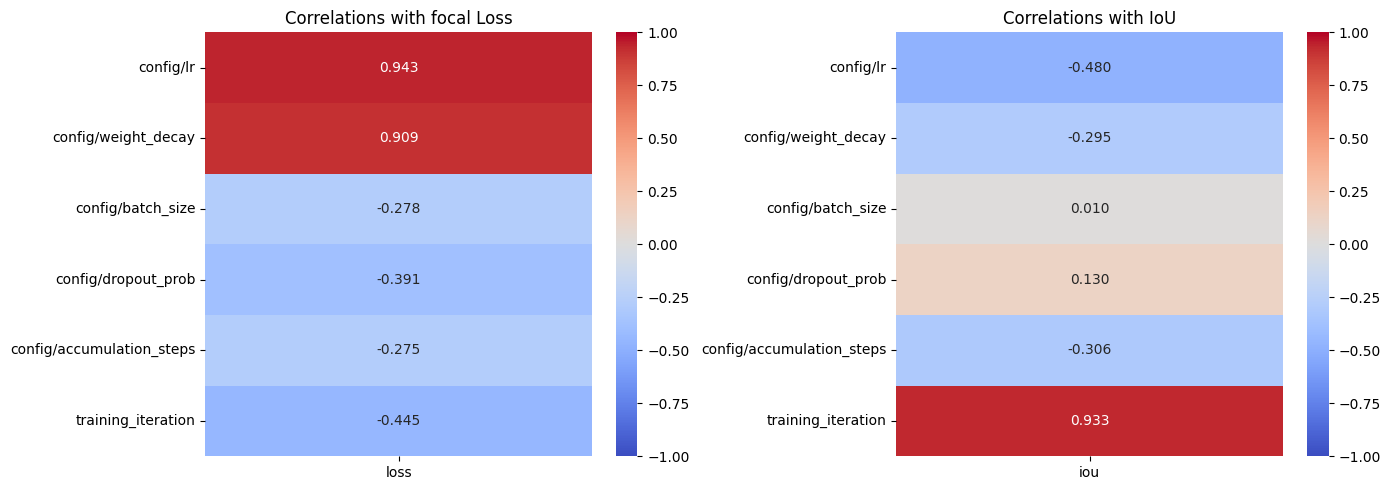

In [19]:
analysis = ExperimentAnalysis("/".join(checkpoint_dir.split("/")[:-1]))

results_df = analysis.dataframe()

param_cols = ['config/lr', 'config/weight_decay', 'config/batch_size', 
              'config/dropout_prob', 'config/accumulation_steps', 'training_iteration']

results_clean = results_df[param_cols + ['loss', 'iou']].dropna()

results_clean['config/batch_size'] = results_clean['config/batch_size'].astype(float)
results_clean['config/accumulation_steps'] = results_clean['config/accumulation_steps'].astype(float)

corr_matrix = results_clean.corr()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(corr_matrix[['loss']].iloc[:-2], annot=True, fmt='.3f', cmap='coolwarm', ax=axes[0], vmin=-1, vmax=1, center=0)
axes[0].set_title('Correlations with focal Loss')

sns.heatmap(corr_matrix[['iou']].iloc[:-2], annot=True, fmt='.3f', cmap='coolwarm', ax=axes[1], vmin=-1, vmax=1, center=0)
axes[1].set_title('Correlations with IoU')

plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()

Based on the correlation matrices, learning rate (0.943) and weight decay (0.909) show extremely strong positive correlations with loss, while learning rate demonstrates moderate negative correlation with IoU (-0.480). However, these correlation values are misleading and should not be interpreted as true measures of hyperparameter importance. The ASHAScheduler terminates poorly performing trials early, which means trials with suboptimal hyperparameters (particularly high learning rates or weight decay) likely stopped after just a few epochs, while better configurations trained longer.

### Conclusions



We chose focal loss because it is used to solve problems of small and unbalanced classes, where instances of small classes suffer more in the loss calculation process. In addition to the loss value, we also looked at the Jaccard index (also known as the IoU score) to see how well the model correctly predicted each pixel.

During inference, the model struggles to detect all details of large objects and particularly small objects. Also, the best model started to overfit after the 5th iteration, even with dropout and batch normalization, which means this architecture is difficult to generalize. IoU (0.33) is gained mainly due to the classification of large objects when small ones do not even appear in the inference